In [ ]:
# some times Tensorflow has problems with memory growth, if that case happens run this cell.
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_virtual_device_configuration(gpu, 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [1]:
import sys
import os
import argparse
import json

from sklearn.model_selection import train_test_split
import datetime as dt

from core.data.data_loader import *
from core.models.lstm import ModelLSTM, ModelLSTMParallel, GaussianLSTM
from core.models.cnn import ModelCNN, ModelCNNParallel
from core.models.mlp import ModelMLP, GaussianMLP
from core.models.rnn import ModelRNN

from core.utils.metrics import *
from core.utils.utils import *

import numpy as np


In [2]:
def manage_models(config):
    
    type_model = config['model']['name']
    model = None

    if type_model == 'lstm': #simple LSTM
        model = ModelLSTM(config)
    elif type_model == 'gaussian-lstm':
        model = GaussianLSTM(config)       
    elif type_model == 'lstm-parallel':
        model = ModelLSTMParallel(config)
    elif type_model == 'cnn':
        model = ModelCNN(config)
    elif type_model == 'cnn-parallel':
        model = ModelCNNParallel(config)        
    elif type_model == 'mlp':
        model = ModelMLP(config)
    elif type_model == 'gaussian-mlp':
        model = GaussianMLP(config)        
    elif type_model == 'simple-rnn':
        model = ModelRNN(config)        

    return model


In [8]:
# reading config file
# load configurations of model and others
#configs = json.load(open('config_lstm_parallel_internal.json', 'r'))
#configs = json.load(open('config_mlp_gaussian.json', 'r'))
configs = json.load(open('config_lstm_gaussian.json', 'r'))


# create defaults dirs
output_bin = configs['paths']['bin_dir']
output_path = configs['paths']['save_dir']
output_logs = configs['paths']['log_dir']
time_steps =  configs['model']['layers'][0]['input_timesteps']  # the number of points or hits
t_features = configs['model']['layers'][0]['input_features']  # the number of features of a tensor
n_features = configs['data']['features']  # the number of features of data input
data_file = configs['data']['filename']
split = configs['data']['train_split']  # the number of features of each hits
cylindrical = configs['data']['cylindrical']  # set to polar or cartesian coordenates
normalise = configs['data']['normalise'] 
num_hits = configs['data']['num_hits']
type_norm = configs['data']['type_norm']
points_3d = configs['data']['points_3d'] # what kind of points: (rho, eta, phi) or (eta, phi)    

type_model = configs['model']['name']
optim = configs['model']['optimizer']
arch = configs['model']['layers']
is_parallel = configs['model']['isparallel']
over_write = configs['model']['overwrite']

loadModel = configs['training']['load_model']
validation_split = configs['training']['validation']
epochs = configs['training']['epochs']
batch = configs['training']['batch_size']
shuffle_train = configs['training']['shuffle']

#create a encryp name for dataset
path_to, filename = os.path.split(data_file)

orig_ds_name = filename

encryp_ds_name = get_unique_name(orig_ds_name)
decryp_ds_name = get_decryp_name(encryp_ds_name)

output_encry = os.path.join(output_path, encryp_ds_name)  
if os.path.isdir(output_bin) == False:
    os.mkdir(output_bin)

if os.path.isdir(output_path) == False: 
    os.mkdir(output_path)

if os.path.isdir(output_encry) == False: 
    os.mkdir(output_encry)

if os.path.isdir(output_logs) == False:
    os.mkdir(output_logs)        
print('Readed')

Readed


In [18]:
# prepare data set
if type_norm == "zscore":
    kind_norm = KindNormalization.Zscore
elif type_norm == "maxmin":
    kind_norm = KindNormalization.Scaling
data = Dataset(data_file, split, cylindrical, num_hits, kind_norm, points_3d=points_3d)

X_train, y_train = data.get_training_data(n_hit_in=time_steps, n_hit_out=1,
                             n_features=2, normalise=normalise)

print('[Data] Shape supervised: X%s y%s :' % (X_train.shape, y_train.shape))
X_train.head()

[Data] Data loaded from  ./dataset/eta_n0.5-0.5_phi_n0.5-0.5_internal_short1.csv
[Data] Data set shape  (10000, 20)
[Data] Data train shape  (8000, 20)
[Data] Data test shape  (2000, 20)
[Data] Data coordinates  cylin
[Data] Shape supervised: X(48000, 8) y(48000, 2) :


,0,1,2,3,4,5,6,7
0,-0.355554,0.490669,-0.210802,0.480547,-0.162189,0.465489,-0.137728,0.441293
1,-0.208280,0.459788,-0.162336,0.447526,-0.138150,0.424148,-0.120286,0.370414
2,-0.160891,0.428166,-0.138395,0.407776,-0.120723,0.355974,-0.110399,0.292228
3,-0.137483,0.390100,-0.121039,0.342224,-0.110845,0.280771,-0.105144,0.183435
4,-0.120512,0.327325,-0.111201,0.269915,-0.105594,0.176129,-0.099405,0.056909


In [19]:
if normalise:
    data.save_scale_param(output_encry)
if type_model == 'lstm' or type_model == 'cnn' or type_model == 'gaussian-lstm':
    if not is_parallel:
        X_train = data.reshape3d(X_train, time_steps, t_features)
    print('[Data] Shape Tensor X_train.shape:', X_train.shape)
elif type_model == 'lstm-parallel' or type_model == 'cnn-parallel':
    if not is_parallel:
        print('DEBUG')

    X_train = np.reshape(X_train.values, (X_train.shape[0], time_steps, n_features))
    #X_train = data.reshape3d(X_train, time_steps, n_features)
    y_train = np.reshape(y_train.values, (y_train.shape[0], n_features))

    X1 = X_train[:,:,0].reshape(X_train.shape[0], X_train.shape[1], t_features)
    X2 = X_train[:,:,1].reshape(X_train.shape[0], X_train.shape[1], t_features)
    X3 = X_train[:,:,2].reshape(X_train.shape[0], X_train.shape[1], t_features)

    Y1 = y_train[:,0].reshape(y_train.shape[0],  t_features)
    Y2 = y_train[:,1].reshape(y_train.shape[0],  t_features)
    Y3 = y_train[:,2].reshape(y_train.shape[0],  t_features)

    X_train = [X1, X2, X3]

print('[Data] Shape Tensor X_train.shape:', X_train.shape)
print('[Data] Shape Tensor y_train.shape:', y_train.shape)


[Data] Shape Tensor X_train.shape: (48000, 4, 2)
[Data] Shape Tensor X_train.shape: (48000, 4, 2)
[Data] Shape Tensor y_train.shape: (48000, 2)


In [11]:
#!pip install livelossplot --quiet
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN
from livelossplot import PlotLossesKeras


In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#physical_devices
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#tf.test.is_gpu_available()


In [12]:
# ejecutado
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
session.close()

In [ ]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

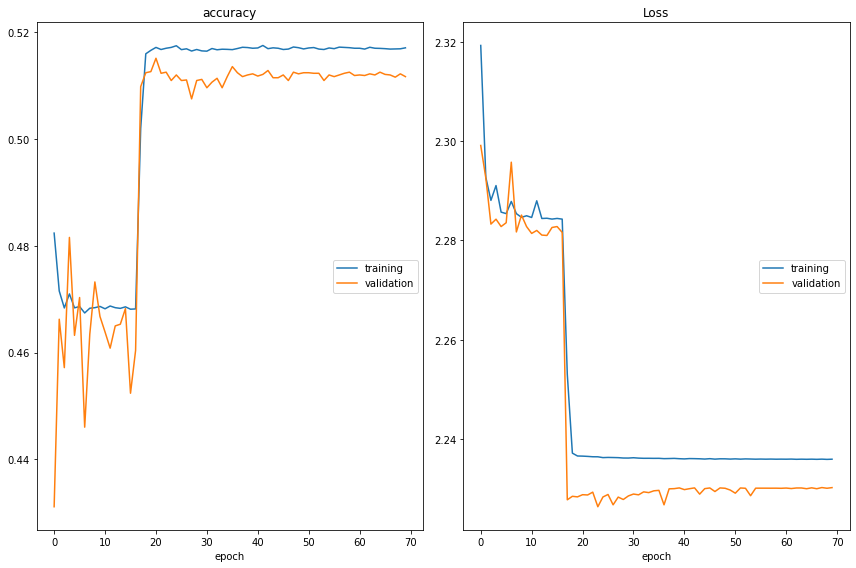

accuracy
	training         	 (min:    0.467, max:    0.517, cur:    0.517)
	validation       	 (min:    0.431, max:    0.515, cur:    0.512)
Loss
	training         	 (min:    2.236, max:    2.319, cur:    2.236)
	validation       	 (min:    2.226, max:    2.299, cur:    2.230)
[Model] Model for inference saved at compiled/model-gaussian-lstm-M8d4WFFi32cAqLf2X3fpNM-coord-cylin-normalise-true-epochs-50-batch-30.h5
[Model] Model training stopped at 0 epoch
[Model] Training Completed. Model h5 saved as compiled/model-gaussian-lstm-M8d4WFFi32cAqLf2X3fpNM-coord-cylin-normalise-true-epochs-50-batch-30.h5
[Model] Model train with structure: [<tf.Tensor 'input_1:0' shape=(None, 4, 2) dtype=float32>]
Time taken: 0:19:32.216546
Time taken: 0:19:32.216803


In [13]:
# training model
model = manage_models(configs)

if model is None:
    print('Please instance model')

show_metrics = configs['training']['show_metrics']
report = ""

if cylindrical:
    coord = 'cylin'
else:
    coord = 'xyz'

ident_name = model.name + "_" + coord 
timer = Timer()

# configure callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
terminate_nan = TerminateOnNaN()
plotlosses = PlotLossesKeras()

if not loadModel:
    if not over_write:
        # if exist, please used the compiled model!
        if model.exist_model(model.save_fnameh5):
            print("[Warning] Please there is a previous model compiled (%s) for %s file." 
                % (model.save_fnameh5, data_file))

    model.build_model()
    save_fname = os.path.join(output_encry, 'architecture_%s.png' % ident_name)
    model.save_architecture(save_fname) 

    timer.start()
    
    check_point = ModelCheckpoint(filepath=model.save_fnameh5, monitor='val_loss', 
                    mode='min', save_best_only=True)
    # live training
    history = model.train(
        x=X_train,
        y=y_train,
        validation=0.1,
        epochs=70,
        verbose=False,
        batch_size=batch,
        shuffle=shuffle_train,
        callbacks=[early_stop, plotlosses, terminate_nan]
    )
    if show_metrics:
        report = evaluate_training(history, output_encry, ident_name)
    timer.stop()
elif loadModel:       
    if not model.load_model():
        print ('[Error] please change the config file : load_model')
session.close()

In [20]:
#history.history
#report = evaluate_training(history, output_encry, ident_name)
print('Final cost: {0:.4f}'.format(history.history['loss'][-1]))
# 0.002, 0.0011
# gaussian 2.2359

Final cost: 2.2360


In [ ]:

# save results in a file    
orig_stdout = sys.stdout
f = open(os.path.join(output_encry, 'results-train.txt'), 'a')
sys.stdout = f

now = dt.datetime.now()
print("[Output] Train results ")
print("---Parameters--- ")
print("\t Model Name        : ", model.name)
print("\t Dataset           : ", model.orig_ds_name)
print("\t Total tracks      : ", len(X_train))
print("\t Path saved        : ", model.save_fnameh5) 
print("\t Coordenate type   : ", coord) 
print("\t Compiled date     : %s taken %s" % (timer.start_dt.strftime("%d/%m/%Y %H:%M:%S"), timer.taken()))    
print("\t Model scaled      : ", model.normalise)
print("\t Model Optimizer   : ", optim)
print("\t Model batch_size  : ", batch)
print("\t Model epochs      : %s  stopped %s " % (epochs, model.stopped_epoch))
print("\t Accuracy          : ", report)
print("\t Architecture      : ", arch)

sys.stdout = orig_stdout
f.close()    

print('[Output] All results saved at %s directory it results-train.txt file. Please use notebooks/plot_prediction.ipynb' % output_encry)    
